# Neural Networks Experiments

## Students: <br>
Tomás Rojas <br>
Matías Montagna <br>
Alonso Utreras

## Using Neural Networks to predict MP 2.5 levels in Temuco, Chile

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import lib.log_info as log

# Get data
all_data = pd.read_csv(r".\data\cleaned-data\temuco_cleaned_data.csv")

# Dropping null values
all_data = all_data.dropna()

all_data["mp_25"] = all_data["mp_2,5"]       # Change names to avoid errors.
all_data = all_data.drop(["mp_2,5"], axis=1) # Drop this column 
all_data[['Day','Hour']] = all_data.datetime.str.split(expand=True) 
all_data['datetime'] = all_data['Day']

# Taking average values of each day
all_data = all_data.groupby(by='Day', as_index=False).mean()


We would like to use values by hours. But the data was too unaccurate  by hours. It was better to work with daily data.

In [13]:
# Showing a example of what we are using as data
all_data.head()


Day  direccion_viento  humedad_relativa  precipitaciones  \
0  2009-01-01        245.391304         59.869565             0.00   
1  2009-01-02        243.041667         64.333333             0.00   
2  2009-01-03        243.083333         62.583333             0.00   
3  2009-01-04        260.333333         74.500000             0.00   
4  2009-01-05        244.625000         79.250000             0.15   

   presion_atmosferica  temperatura_ambiente  velocidad_viento      mp_25  
0          1001.260870             17.173913          2.313043  14.169563  
1          1005.125000             16.312497          2.274999  12.483332  
2          1001.424750             17.870833          2.195833  12.004165  
3          1002.333333             15.983333          2.274999   9.233333  
4          1004.083333             16.733333          2.129167  10.399998

As we can see, there are too many inputs with low $MP_{2.5}$ values. Thus, a NN is very likely to overfit the most values. In order to avoid this, we are going to drop the lower values.

(array([2.279e+03, 6.000e+02, 2.490e+02, 1.180e+02, 5.400e+01, 2.100e+01,
        9.000e+00, 3.000e+00, 3.000e+00, 1.000e+00]),
 array([  1.22916667,  37.57845   ,  73.92773333, 110.27701667,
        146.6263    , 182.97558333, 219.32486667, 255.67415   ,
        292.02343333, 328.37271667, 364.722     ]),
 <a list of 10 Patch objects>)

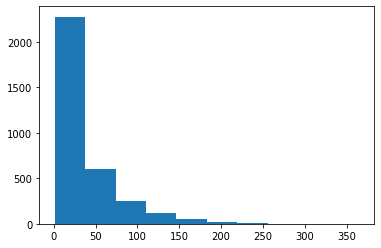

In [14]:
plt.hist(all_data.mp_25)

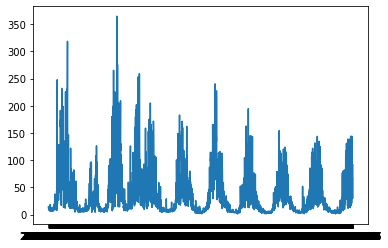

In [15]:
# Plotting MP 2.5 levels vs day
days = all_data.Day
mp_levels = all_data.mp_25

plt.plot(days, mp_levels)

(array([729., 283., 138.,  72.,  34.,  17.,   5.,   2.,   3.,   1.]),
 array([ 30.    ,  63.4722,  96.9444, 130.4166, 163.8888, 197.361 ,
        230.8332, 264.3054, 297.7776, 331.2498, 364.722 ]),
 <a list of 10 Patch objects>)

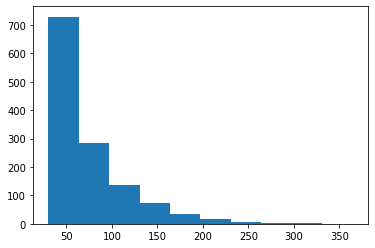

In [16]:
# Erasing low mp 2.5 level days
all_data = all_data.drop(all_data[all_data.mp_25 < 30].index)
plt.hist(all_data.mp_25)


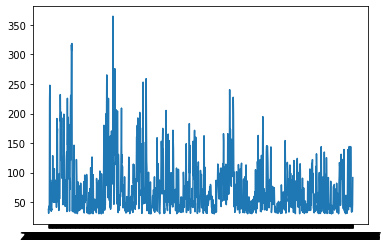

In [17]:
# Plotting MP 2.5 levels vs day
days = all_data.Day
mp_levels = all_data.mp_25

plt.plot(days, mp_levels)

### Dividing data into train, test and validation sets
We chose a train size of 70% of all data, while 15% corresponds to test and 15% to validation data.

In [55]:
# Creating input and output data
X = all_data.iloc[:, 1:-1] # TODO: You could add datetime by writing a 0 instead of a 1
Y = all_data.iloc[:, -1]

X.head()

direccion_viento  humedad_relativa  precipitaciones  presion_atmosferica  \
70        244.250000         75.708333         0.000000          1003.625000   
78        235.541667         77.958333         0.000000          1005.208333   
89        154.083333         75.083333         0.000000          1007.916667   
90        165.541667         75.708333         0.008333          1000.107667   
94        107.416667         90.083333         0.945833          1002.416667   

    temperatura_ambiente  velocidad_viento  
70             16.845833          1.779167  
78             15.679167          1.887500  
89             11.670832          0.737500  
90             14.408331          1.450000  
94             13.520833          1.716667

In [57]:
all_data.Day = pd.to_datetime(all_data.Day)


### Setting device to work with. Use cuda if available.

In [59]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Classes for training our models:

## LSTM model

In [146]:
import torch.nn as nn
import torch.nn.functional as F


class LSTMModel(nn.Module):
    """LSTM layer + linear to get output"""

    def __init__(self, input_size, n_hidden=16, n_layers=3,  output_size=1, model_name="LSTM", batch_size=1, dropout=0.2):
        super().__init__()
        
        self.input_size = input_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=dropout
        )

        self.hidden_cell = (torch.zeros(1, 1, self.n_hidden),
                            torch.zeros(1, 1, self.n_hidden))

        self.linear = nn.Linear(in_features=n_hidden, out_features=output_size)
        self.name = model_name
        # error with double type

        #h_0 of shape (num_layers * num_directions, batch, hidden_size)
        #c_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial cell state for each element in the batch.

    def reset_hidden_state(self):
        """Initialize hidden state"""
        self.hidden = (
            torch.zeros(self.n_layers, self.batch_size, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.batch_size, self.n_hidden).to(device)
            )

    def forward(self, _input):
        # if len(_input.size()) == 3:
        #     seq_len = _input.size()[1]

        # if len(_input.size()) == 2:
        #     seq_len = _input.size()[0]

        # (seq_len, batch, input_size)
        # _input = _input.view(seq_len, self.batch_size , self.input_size).float()


        _input = _input.view(1, 1 , len(_input)).float()

        lstm_out, self.hidden = self.lstm(_input, self.hidden)
        lstm_out = lstm_out.float()

        y_pred = self.linear(lstm_out.view(self.n_hidden)).float()
        # y_pred = self.linear(lstm_out.view(lstm_out, -1)).float()
  
        return y_pred

# Setting model to use and its name
model_name = "Temp PM LSTM 3 layers. 128 hidden size"
    # def __init__(self, input_size, n_hidden=16, n_layers=3,  output_size=1, model_name="LSTM", batch_size=1, dropout=0.2):

inputs_types = (list(X.columns))
input_size = len(inputs_types) # Temp, Precipitaciones, Humidity, Wind speed, wind dir, pressure
seq_len = 365 # Days in a year

model_1_temp_pm = LSTMModel(
    input_size = input_size,
    n_hidden = 64,
    n_layers = 3,
    output_size = 1,
    model_name = "Temp PM LSTM 3 layers. 128 hidden size",
    batch_size = 1,
    dropout = 0.2) # Adding Dropout to avoid overfitting

loss_1 = nn.MSELoss()

# Setting model, loss and optimizer
model = model_1_temp_pm.to(device)
loss = loss_1.to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Setting logger
Logger = log.LogInfo(
    model=model, 
    logging_name=model_name
    )
Logger.add_info("Model using LSTM. hidden dim = 128.\n Having 3 layers.\n Data unnormalized")

# Hyperparamters
n_epochs = 5

## Training function

In [118]:
import time

def init_weights(model):
    # Inicializamos los pesos como aleatorios
    for name, param in model.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.1) 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def create_inout_sequences(training_data, train_window=365):
    """TODO: FIX for our data. We still don't know  how our data is going to be.  """
    inout_seq = []
    L = len(training_data)
    for i in range(L-train_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window:i+train_window+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq


def train(model, x_train, y_train, optimizer, loss_function, epochs=5, batch_size=365*24):
    model.train()
    total_loss = 0

    for i in range(epochs):
        # each epoch
        epoch_loss = 0
        best_test_loss = float('inf')

        for x_i, y_i in zip(x_train, y_train):
            # Each batch
            # initialize the hidden state.
            model.reset_hidden_state()

            x_i = x_i.to(device)
            y_i = y_i.to(device).float()
            optimizer.zero_grad()
            y_pred = model(x_i).float()

            loss = loss_function(y_pred, y_i).float()
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Save results from the best trained model
        if epoch_loss < best_test_loss:
            best_test_loss = epoch_loss
            torch.save(model.state_dict(), '{}.pt'.format(model.name))
            
        total_loss += epoch_loss
        print(f'epoch: {i} loss: {epoch_loss:10.8f}')

    print(f'Average loss: {total_loss/len(x_train):4f}')
    return total_loss

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def test(model, x_test, y_test, loss_function, batch_size=365):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x_i, y_i in zip(x_test, y_test):
            # predict data using the given model
            model.reset_hidden_state()
            
            x_i = x_i.to(device)
            y_i = y_i.to(device).float()
            
            prediction = model(x_i) # Predict value
            
            total_loss += loss_function(prediction, y_i).float().item() 

    return total_loss

def load_best_model(model):
    return model.load_state_dict(torch.load(f'{model.name}.pt'))

### Execute Training and Testing:

In [63]:
# Execute training
def execute_training(model, x_train, y_train, x_test, y_test, optimizer, loss_function, logger, n_epochs=5, batch_size=365*24):
    # Train

    start_time = time.time()
    train_loss = train(model, x_train, y_train, optimizer, loss_function, n_epochs, batch_size)
    end_time = time.time();
    train_time = end_time - start_time

    print(f'Training time = {train_time}')
    print(f'Train Loss: {train_loss}')


    # Test
    start_time = time.time()

    test_loss = test(model, x_test, y_test, loss_function, batch_size)
    end_time = time.time()
    test_time = end_time - start_time 

    print(f'\t Val. Loss: {test_loss:.3f}')

    logger.model_loss['train'] = train_loss
    logger.model_loss['test'] = test_loss
    logger.set_train_test_size(x_train, x_test)
    logger.set_training_time(train_time)
    # logger.set_epochs(n_epochs)
    # logger.set_optimizer(optimizer)



In [105]:
# Clean CUDA RAM
torch.cuda.empty_cache()

## Train and Test model 

### Normalizing train data:
We read here https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
that it is important to normalize data when working with time series. 


In [92]:
# Splitting data into train and test sets

_X_train, _X_test, _y_train, _y_val  = train_test_split(X, Y, test_size=0.3, random_state=42)

2316

In [93]:
from sklearn.preprocessing import MinMaxScaler


# scaler = MinMaxScaler(feature_range=(-1, 1))
# X_train_normalized = scaler.fit_transform(x_train_np)
# y_train_normalized = scaler.fit_transform(y_train_np.reshape(-1, 1))

_X_train = np.asarray(_X_train.values)
_X_test = np.asarray(_X_test.values)
_y_train = np.asarray(_y_train.values)
_y_test = np.asarray(_y_val.values)

X_train = torch.from_numpy(_X_train).to(device)
X_test = torch.from_numpy(_X_test).to(device)
y_train = torch.from_numpy(_y_train).to(device)
y_test = torch.from_numpy(_y_test).to(device)

# Transforming data into tensors
# X_tensor = X_train.view(X_train.size()[0], 1, X_train.size()[1])
# X_tensor = X_tensor.transpose(0, 1)

# train_data_normalized = torch.FloatTensor(X_train).view(-1)

In [95]:
print(X_train.size())
print(y_train.size())


torch.Size([898, 6])
torch.Size([898])


### Transforming data Shape to work well with batches and our models.

In [74]:
# X_train = X_train.transpose(0, 1)
# y_train = y_train.transpose(0, 1)
# y_tensor = y_train.view(1, -1)
# X_tensor = X_tensor.transpose(0, 1)
# y_tensor = y_tensor.transpose(0, 1)

In [68]:
# y_tensor.size()

torch.Size([1, 898])

In [77]:
# y_test.size()

NameError: name 'y_test' is not defined

In [15]:
# y_train.size()

torch.Size([1, 1000])

In [147]:
print(f'The current model contains {count_parameters(model)} trainable parameters.')     
model = model.float()
model.apply(init_weights)


execute_training(
    model=model,
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    optimizer=optimizer,
    loss_function=loss,
    logger=Logger,
    n_epochs=n_epochs
    )

The current model contains 85057 trainable parameters.
epoch: 0 loss: 2567905.56820981
epoch: 1 loss: 1827652.95748426
epoch: 2 loss: 1825949.57873394
epoch: 3 loss: 1826020.49810104
epoch: 4 loss: 1826053.29208566
Average loss: 10995.080061
Training time = 26.603370428085327
Train Loss: 9873581.894614689
689957.0347397365
	 Val. Loss: 689957.035


In [148]:
load_best_model(model)

# Export info to a logger to store results
# Logger.export_info()

<All keys matched successfully>

### Plotting predicted data vs real data using testing set

In [122]:
import matplotlib.pyplot as plt

y_pred = model(X_train)

X_train_np = X_train.cpu().detach().numpy()
y_train_np = y_train.cpu().detach().numpy().reshape(-1)

y_pred_plot = y_pred.cpu().detach().numpy().reshape(-1)

actual_values = \
    scaler.inverse_transform(y_train_np.reshape(-1, 1))

actual_predictions = \
    scaler.inverse_transform(y_pred_plot.reshape(-1, 1))

# actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

fig, ax = plt.subplots()

plt.plot(actual_values, marker="*", label="results")
plt.plot(actual_predictions, marker="+", label="predictions")

plt.show()

RuntimeError: shape '[1, 1, 898]' is invalid for input of size 5388

In [124]:
# Transform tensors to numpy arrays
y_pred = model(X_test)
# X_test_np = X_test.cpu().detach().numpy()
# y_test_np = y_test.cpu().detach().numpy()
# y_pred_np = y_pred.cpu().detach().numpy()


fig, ax = plt.subplots()

# plot both real values and prediction values
results_plot = plt.scatter(X_test_np, y_test_np, marker="*", label="results")
pred_plot = plt.scatter(X_test_np, y_pred_np, marker="+", label="predictions")

ax.legend()            
plt.xlabel("temperature")
plt.ylabel("mp2.5")
plt.title(model.name)

# plot results and store it in results directory
plt.show()
plt.savefig(f'./results/{model.name}')

RuntimeError: shape '[1, 1, 386]' is invalid for input of size 2316

In [149]:
predicted_values = np.zeros(X_train.size()[0])
real_values = np.zeros(y_train.size()[0])

with torch.no_grad():

    for index, (x_i, y_i) in enumerate(zip(X_train, y_train)):
        model.reset_hidden_state()
        
        x_i = x_i.to(device)
        y_i = y_i.to(device).float()
        
        prediction = model(x_i)

        real_values[index] = y_i
        predicted_values[index] = prediction


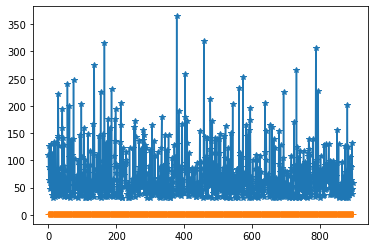

In [145]:
fig, ax = plt.subplots()

plt.plot(real_values, marker="*", label="results")
plt.plot(predicted_values, marker="+", label="predictions")

plt.show()